In [1]:
import pandas as pd
from datetime import datetime

In [2]:
NasData = pd.read_csv('NAS.csv')

In [3]:
NasData['Price']

0      11,816.32
1      11,584.55
2      11,393.81
3      11,621.71
4      11,512.41
         ...    
245    14,490.37
246    14,194.46
247    14,015.67
248    14,098.01
249    13,878.82
Name: Price, Length: 250, dtype: object

In [4]:
NasData.index = list(map(lambda dt: datetime.strptime(dt, '%m/%d/%Y'), NasData['Date']))
NasData['Price'] = list(map(lambda nasPrice: float(nasPrice.replace(',', '')), NasData['Price']))

In [5]:
NasDf = NasData.sort_index()

In [6]:
NasDf

,Date,Price,Open,High,Low,Vol.,Change %
2022-02-03,02/03/2022,13878.82,"14,045.83","14,207.88","13,851.75",945.51M,-3.74%
2022-02-04,02/04/2022,14098.01,"13,958.48","14,222.76","13,850.39",862.97M,1.58%
2022-02-07,02/07/2022,14015.67,"14,118.79","14,236.31","13,974.10",858.02M,-0.58%
2022-02-08,02/08/2022,14194.46,"13,984.43","14,226.48","13,934.78",865.50M,1.28%
2022-02-09,02/09/2022,14490.37,"14,368.16","14,490.72","14,330.87",935.01M,2.08%
...,...,...,...,...,...,...,...
2023-01-26,01/26/2023,11512.41,"11,458.41","11,516.05","11,341.19",992.60M,1.76%
2023-01-27,01/27/2023,11621.71,"11,470.47","11,691.89","11,470.27",1.05B,0.95%
2023-01-30,01/30/2023,11393.81,"11,512.34","11,553.31","11,388.54",954.43M,-1.96%
2023-01-31,01/31/2023,11584.55,"11,398.58","11,586.01","11,398.37",1.15B,1.67%


In [7]:
import pandas as pd
import numpy as np
import talib as ta
import os
import matplotlib.pyplot as plt
import warnings
import pymongo
from datetime import datetime, timedelta
import mplfinance as mpf
import scipy.stats as stats
warnings.filterwarnings('ignore')
# week day setting
def prepareData(collection, startTime, endTime, rsPeriod):
    data_df = pd.DataFrame(
        list(collection.find({"datetime": {'$gt': startTime, '$lt': endTime}}))
    )
    data = data_df[['datetime', 'open', 'high', 'low', 'close', 'volume']].copy()
    hlcvDict = {'open':'first', 'high':'max', 'low':'min', 'close': 'last','volume':'sum'}
    data = data.set_index('datetime')
    dataDf = data.resample(rsPeriod, closed='right', label='right').apply(hlcvDict)
    dataDf = dataDf.dropna()
    return dataDf

symbolsList = ['eth_usdt.spot:binance', 'btc_usdt.spot:binance', 'uni_usdt.spot:binance', 
          'link_usdt.spot:binance', 'matic_usdt.spot:binance', 'axs_usdt.spot:binance']
client = pymongo.MongoClient('172.16.20.81', 27017)
collectionEth = client['Kline_1Min_Auto_Db_Plus'][symbolsList[1]]
startTime = datetime(2022,3,1)
endTime = datetime(2023,1,31)
rsPeriod = 'D'
dataCoin = prepareData(collectionEth, startTime, endTime, rsPeriod)

In [8]:
dataCoin

,open,high,low,close,volume
datetime,,,,,
2022-03-02,40854.51,44949.00,40693.18,43638.75,79015.04913
2022-03-03,43638.74,45400.00,43111.46,44055.43,60048.89827
2022-03-04,44053.59,44498.02,42348.56,42499.99,47325.57749
2022-03-05,42499.99,42750.00,40550.04,40747.11,55691.25899
2022-03-06,40748.19,40958.66,38407.59,39189.01,44469.91222
...,...,...,...,...,...
2023-01-27,22570.95,23816.73,22510.00,22970.94,350155.27233
2023-01-28,22970.94,23195.00,22534.88,22963.15,243423.49719
2023-01-29,22964.83,23500.00,22878.46,23015.45,197325.68818


In [9]:
corrDf = pd.concat([dataCoin['close'], NasDf['Price']], axis=1)

In [10]:
corrDf = corrDf.dropna()

In [11]:
corrDf.columns = ['btcPrice', 'nasPrice']

In [12]:
corrDf['Year'] = corrDf.index.year

In [23]:
corrDf['Month'] = corrDf.index.month

In [24]:
corrDf

,btcPrice,nasPrice,Year,btcLogPrice,nasLogPrice,Month
2022-03-02,43638.75,13752.02,2022,10.683701,9.528941,3
2022-03-03,44055.43,13537.94,2022,10.693204,9.513251,3
2022-03-04,42499.99,13313.44,2022,10.657259,9.496529,3
2022-03-07,38812.36,12830.96,2022,10.566494,9.459616,3
2022-03-08,39090.98,12795.55,2022,10.573647,9.456853,3
...,...,...,...,...,...,...
2023-01-25,22927.36,11313.36,2023,10.040086,9.333740,1
2023-01-26,22572.08,11512.41,2023,10.024469,9.351181,1
2023-01-27,22970.94,11621.71,2023,10.041985,9.360630,1
2023-01-30,23530.93,11393.81,2023,10.066071,9.340826,1


In [26]:
corrDf['btcLogPrice'] = np.log(corrDf['btcPrice'])
corrDf['nasLogPrice'] = np.log(corrDf['nasPrice'])

In [31]:
corrDf

,btcPrice,nasPrice,Year,btcLogPrice,nasLogPrice,Month
2022-03-02,43638.75,13752.02,2022,10.683701,9.528941,3
2022-03-03,44055.43,13537.94,2022,10.693204,9.513251,3
2022-03-04,42499.99,13313.44,2022,10.657259,9.496529,3
2022-03-07,38812.36,12830.96,2022,10.566494,9.459616,3
2022-03-08,39090.98,12795.55,2022,10.573647,9.456853,3
...,...,...,...,...,...,...
2023-01-25,22927.36,11313.36,2023,10.040086,9.333740,1
2023-01-26,22572.08,11512.41,2023,10.024469,9.351181,1
2023-01-27,22970.94,11621.71,2023,10.041985,9.360630,1
2023-01-30,23530.93,11393.81,2023,10.066071,9.340826,1


In [32]:
corrLogDf = corrDf[['btcLogPrice', 'nasLogPrice']]

In [36]:
# corrLogDfG = corrLogDf.groupby('Month').corr()
corrLogDfG = corrLogDf.rolling(30).corr()

In [37]:
corrLogDfG

btcLogPrice  nasLogPrice     Month
2022-03-02 btcLogPrice          NaN          NaN       NaN
           nasLogPrice          NaN          NaN       NaN
           Month                NaN          NaN       NaN
2022-03-03 btcLogPrice          NaN          NaN       NaN
           nasLogPrice          NaN          NaN       NaN
...                             ...          ...       ...
2023-01-30 nasLogPrice     0.896052     1.000000 -0.570031
           Month          -0.552608    -0.570031  1.000000
2023-01-31 btcLogPrice     1.000000     0.906061 -0.570052
           nasLogPrice     0.906061     1.000000 -0.593440
           Month          -0.570052    -0.593440  1.000000

[693 rows x 3 columns]

In [49]:
corr = corrLogDfG['btcLogPrice'].unstack()['nasLogPrice']

In [50]:
corrLogDfG['btcLogPrice'].unstack()

,Month,btcLogPrice,nasLogPrice
2022-03-02,NaN,NaN,NaN
2022-03-03,NaN,NaN,NaN
2022-03-04,NaN,NaN,NaN
2022-03-07,NaN,NaN,NaN
2022-03-08,NaN,NaN,NaN
...,...,...,...
2023-01-25,-0.520327,1.0,0.720698
2023-01-26,-0.533162,1.0,0.786499
2023-01-27,-0.539204,1.0,0.862342
2023-01-30,-0.552608,1.0,0.896052


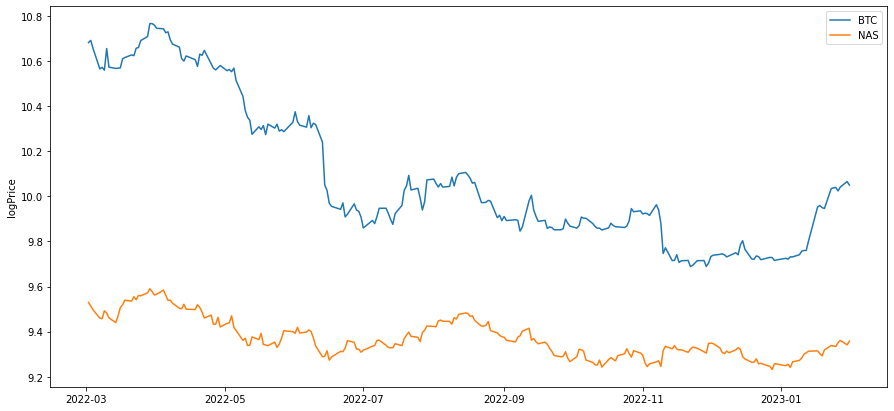

In [51]:
plt.figure(figsize=(15, 7))
# plt.plot(corrDf['btcLogPrice'].loc[datetime(2022,1,1):datetime(2022,12,31)])
# plt.plot(corrDf['nasLogPrice'].loc[datetime(2022,1,1):datetime(2022,12,31)])
plt.plot(corrDf['btcLogPrice'])
plt.plot(corrDf['nasLogPrice'])
plt.ylabel('logPrice')
plt.legend(['BTC','NAS'])
plt.show()

In [52]:
corr

2022-03-02         NaN
2022-03-03         NaN
2022-03-04         NaN
2022-03-07         NaN
2022-03-08         NaN
                ...   
2023-01-25    0.720698
2023-01-26    0.786499
2023-01-27    0.862342
2023-01-30    0.896052
2023-01-31    0.906061
Name: nasLogPrice, Length: 231, dtype: float64

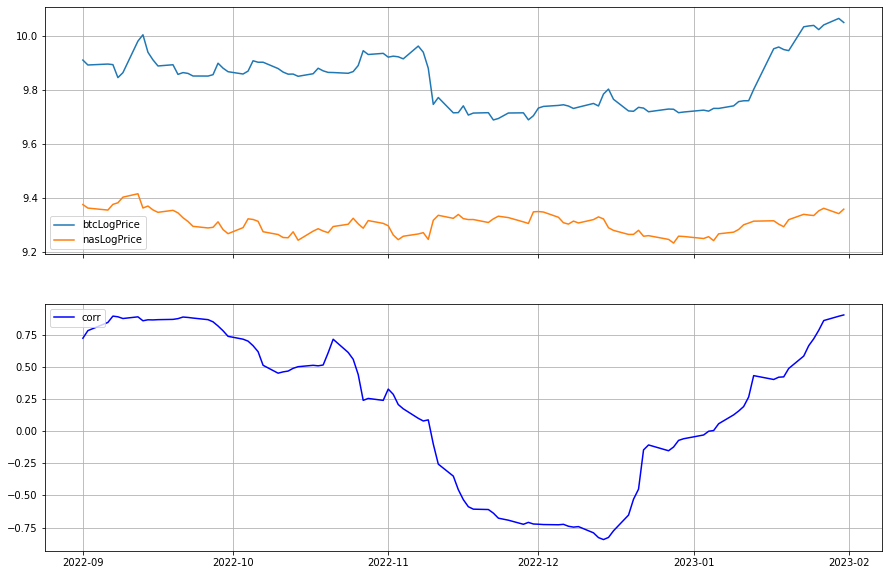

In [56]:
fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(15,10))
ax.grid(True)
ax.plot(corrDf['btcLogPrice'].loc[datetime(2022,9,1):], label='btcLogPrice')
ax.plot(corrDf['nasLogPrice'].loc[datetime(2022,9,1):], label='nasLogPrice')
ax.legend()
ax1.plot(corr.loc[datetime(2022,9,1):], color='b', label='corr')
ax1.legend(loc='upper left')
ax1.grid()
fig.savefig('corr')